# Exploratory Data Analysis

In this notebook, the analysis made on data are written to understand which transformation were applied to the dataset to increase learning speed.

## Visualize data

Let's start by visualizing some of the samples in our dataset.
In the cells below, first the paths of all the video is loaded, and then we visualize the video loaded into memory.

In [1]:
from glob import glob
import sys
import os

current_path = !pwd
current_path = current_path[0]
video_dir = os.path.join(current_path, "mocogan", "resized_data")
video_paths = glob(os.path.join(video_dir, "*", "*"))

video_raw_dir = os.path.join(current_path, "mocogan", "raw_data")
video_raw_paths = glob(os.path.join(video_raw_dir, "*", "*"))

print(f"A video path is {video_paths[0]}")
print(f"A raw video path is {video_raw_paths[0]}")

A video path is /home/carlo/Documenti/Text2VideoGAN/mocogan/resized_data/Haircut/v_Haircut_g20_c05.mp4
A raw video path is /home/carlo/Documenti/Text2VideoGAN/mocogan/raw_data/Haircut/v_Haircut_g09_c07.avi


In [2]:
from IPython.display import Video
import numpy as np

randomVideoIdx = np.random.randint(0, len(video_paths))
randomVideo = video_paths[randomVideoIdx]
randomVideoClass = randomVideo.split(os.sep)[-2]

print(f"Class of video chosen is: {randomVideoClass}")
Video(randomVideo, embed= True)

Class of video chosen is: Rowing


## Raw data

Since we are exploring data in our dataset, let's try to see how it is possible to exploit dta augmentation with raw_data. 
Raw_data is the dataset that has not been processed by the script named `resize.py`: this will process videos to do downScaling from `320x240` to `96x96`.

In [3]:
from IPython.display import Video
import numpy as np

randomVideoIdx = np.random.randint(0, len(video_raw_paths))
randomVideo = video_raw_paths[randomVideoIdx]
randomVideoClass = randomVideo.split(os.sep)[-2]

print(f"Class of video chosen is: {randomVideoClass}")
Video(randomVideo, embed= True)

Class of video chosen is: Diving


## Display frames from video

In this cell the video chosen before will be loaded with the same method used to load video into the notebook called `Train`.

The method uses the library Imageio that should come already installed with Ananconda.

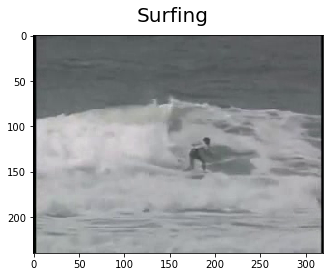

In [13]:
from mocogan.models import readVideoImageio
import pylab

def showFrame(frame, title = "Image"):
    fig = pylab.figure()
    fig.suptitle(title, fontsize=20)
    pylab.imshow(frame)
    pylab.show()


video = readVideoImageio(randomVideo)
randomFrameIdx = np.random.randint(0, len(video))

showFrame(video[randomFrameIdx], randomVideoClass)

## Torch VideoVision Repository

To perform data augmentation, the repository https://github.com/hassony2/torch_videovision.git was forked to add some transformation to the ones already implemented, since TorchVision in its current implementation does not provide Transformations for videos.

In the cells below, first the video path is loaded and then some transformations that were done to videos are shown.

/home/carlo/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


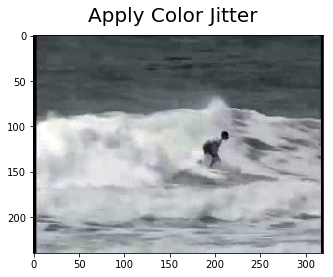

In [5]:
from torch_videovision.videotransforms.video_transforms import ColorJitter, TemporalCrop    
from torch_videovision.videotransforms.volume_transforms import ToTensor, ClipToTensor
from torchvision.transforms import Lambda, Compose

transformation = Compose([ ClipToTensor(numpy = True)])

jitter = ColorJitter(brightness=1, contrast=1, saturation=1, hue=0.5) #Max values

jitteredVideo = jitter(video)

showFrame(jitteredVideo[randomFrameIdx], "Apply Color Jitter")

## Pipeline of transformations

Here the transformations to do data augmentation are done onto a video to show the results.

1. TransposeChannels is a simple transformation that transpose the numpy ndarray `(#Frames x Height x Width x #Channels)` into the expected format for the other transformation, that is `(#Channels x #Frames x Height x Width)`
2. RandomTemporalCrop takes only max_frame frames from the video, but takes them starting from a random index every time.
3. SpatialRandomCrop is a crop applied in a random way to take only a portion of the video. However, this will not be used since in the raw video, too much details would be useless.
4. RandomHorizontalFlip will flip horizontally in a random way the video.
5. TransposeChannels with `reverse = True` means that the First transformation will be reversed to return in a `(#Frames x Height x Width x #Channels)` format.
6. ColorJitter will perform color changes, however it is preferred to use small values for jittering: as sometimes it may be seen above, changing too much the brightness can make the video too dark and nothing can be seen.
7. ClipToTensor will transform into a FloatTensor and divide for 255.
8. Normalize will normalize data between $[-0.5, 0.5]$

However, as it will be seen below, this transformations with the size of video will have the effect of cropping out of the video the action: since we don't want this to happen, two choises can be done:
1. Increment size of SpatialRandomCrop and then apply a Resize to use `96 x 96` dimensions.
2. Use `resized_data` folder with all videos with `96 x 96` dimensions, and do not crop out useless context informations.

In [6]:
from torch_videovision.videotransforms.video_transforms import ColorJitter, RandomTemporalCrop, RandomHorizontalFlip, RandomCrop, Resize
from torch_videovision.videotransforms.volume_transforms import ToTensor, ClipToTensor, TransposeChannels
from torch_videovision.videotransforms.tensor_transforms import Normalize, SpatialRandomCrop

from torchvision.transforms import Compose

/home/carlo/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [7]:
img_size  = 96
max_frame = 25
stdDev    = 0.5
medium    = 0.5

transformation = Compose([  TransposeChannels(),
                            RandomTemporalCrop(max_frame),
                            SpatialRandomCrop( (img_size, img_size) ),
                            RandomHorizontalFlip(),
                            TransposeChannels(reverse = True),
                            ColorJitter(brightness = 0.2, contrast = 0.5, saturation = 0.5, hue = 0.1), #Max Values for Color Jitter
                            ClipToTensor(div_255= True),
                            Normalize(medium, stdDev)
                         ])

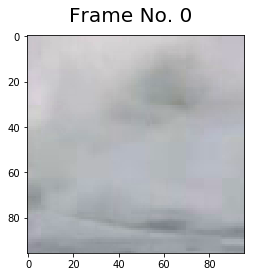

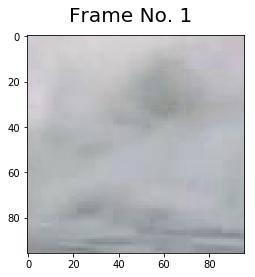

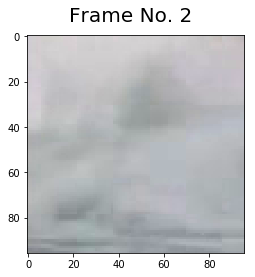

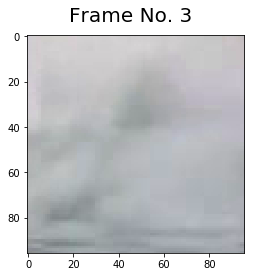

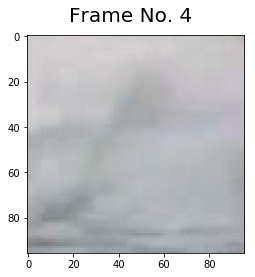

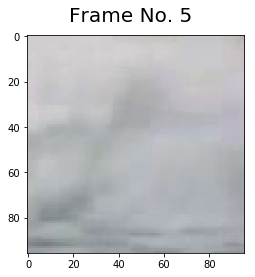

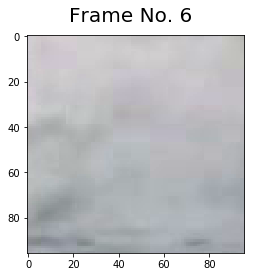

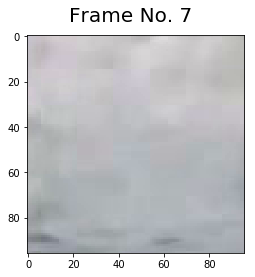

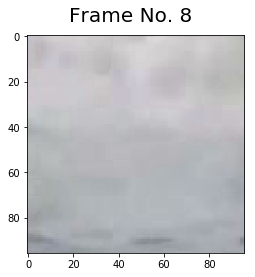

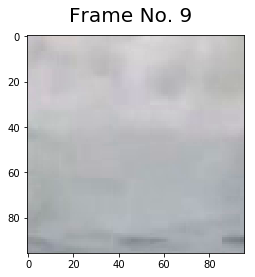

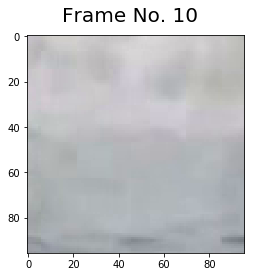

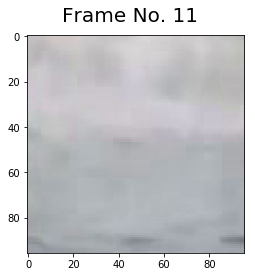

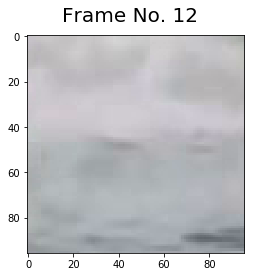

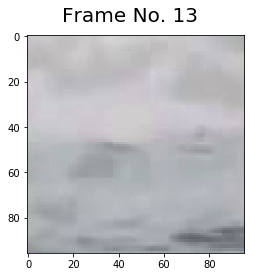

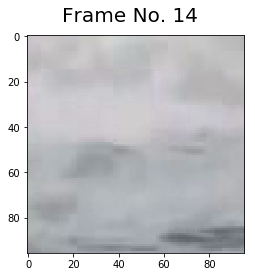

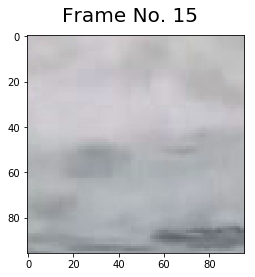

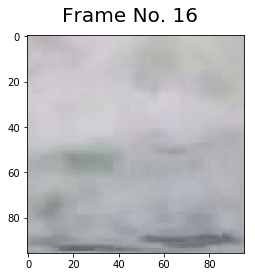

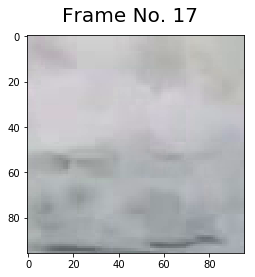

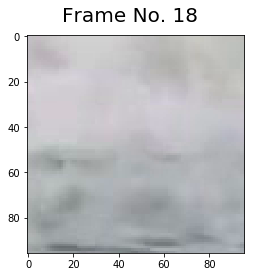

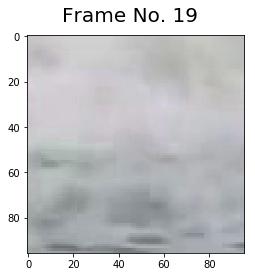

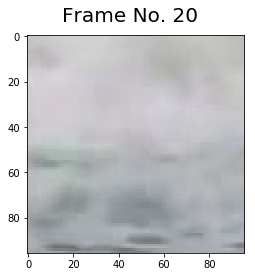

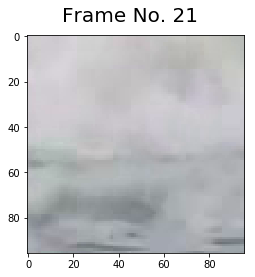

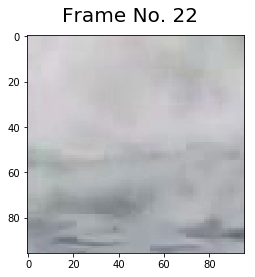

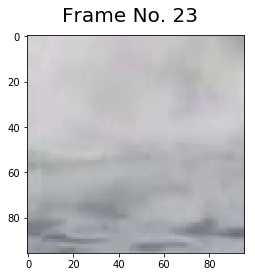

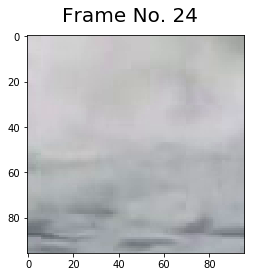

In [8]:
augmentedVideo = transformation(video)

newRandomFrameIdx = np.random.randint(0, augmentedVideo.shape[1])

# Since there is the Normalization applied, must de apply it.
augmentedVideo = augmentedVideo.numpy().transpose(1, 2, 3, 0)
augmentedVideo = augmentedVideo * stdDev + medium

for idx, frame in enumerate(augmentedVideo):
    showFrame(frame, f"Frame No. {idx}")

## Final Compose

The final pipeline of the transformation will be the one below.

In [9]:
img_size  = 96
max_frame = 25
stdDev    = 0.5
medium    = 0.5

final_transformation = Compose([  TransposeChannels(),
                            RandomTemporalCrop(max_frame),
                            SpatialRandomCrop( (img_size * 2, img_size * 3) ),
                            RandomHorizontalFlip(),
                            TransposeChannels(reverse = True),
                            Resize((img_size, img_size), interpolation='bilinear'),
                            ColorJitter(brightness = 0.2, contrast = 0.7, saturation = 0.5, hue = 0.1), #Max Values for Color Jitter
                            ClipToTensor(div_255= True),
                            Normalize(medium, stdDev)
                         ])

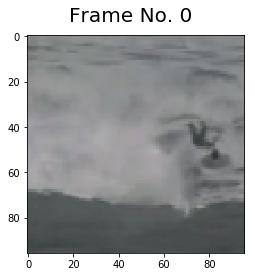

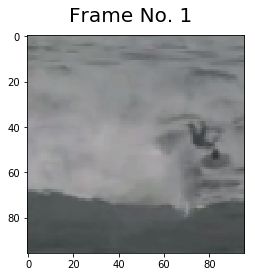

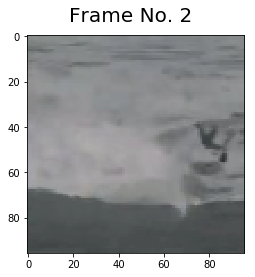

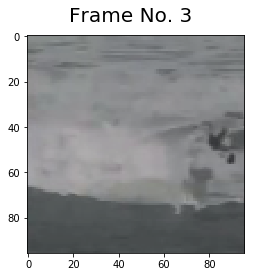

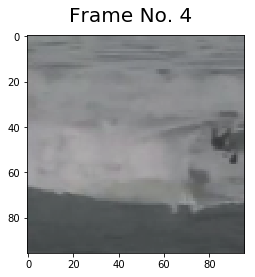

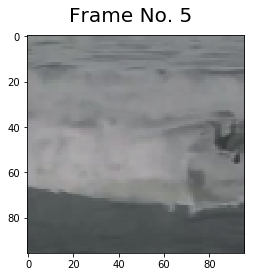

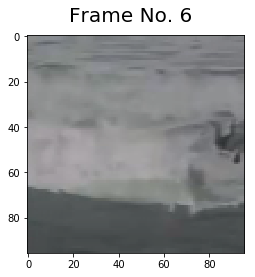

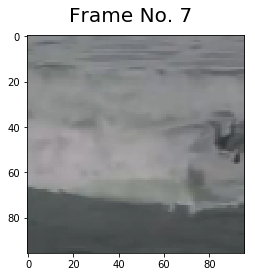

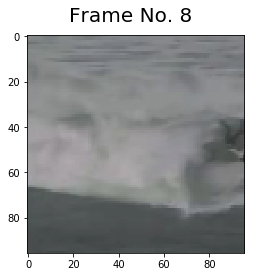

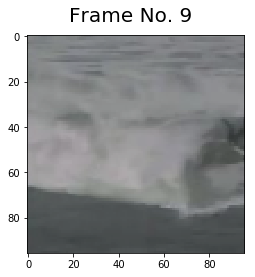

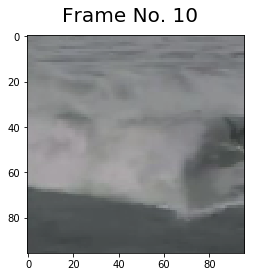

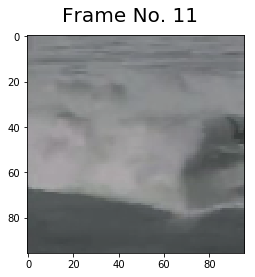

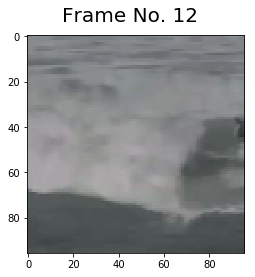

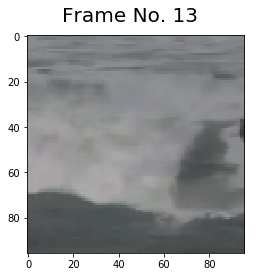

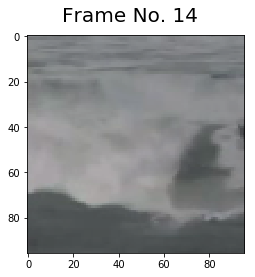

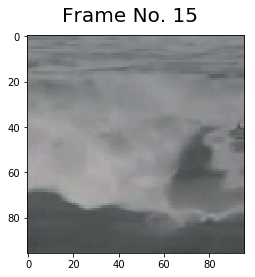

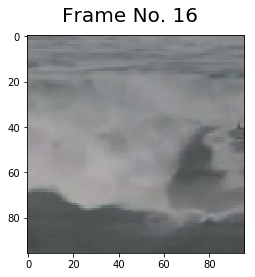

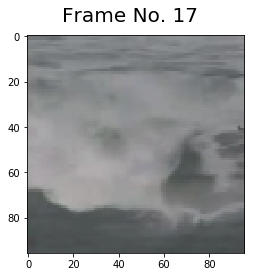

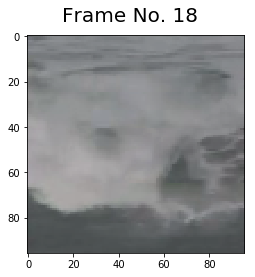

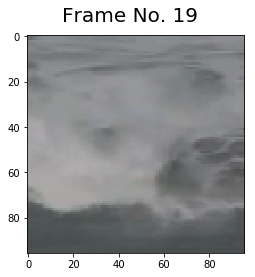

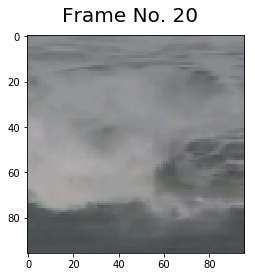

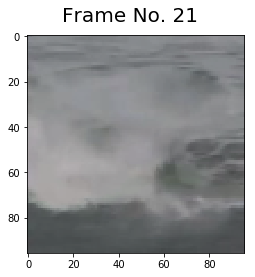

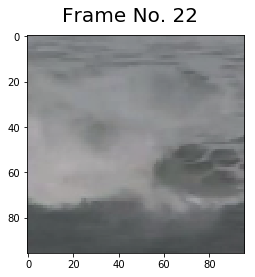

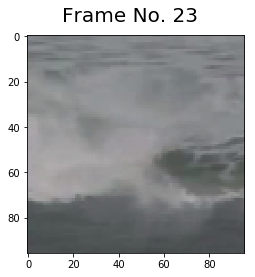

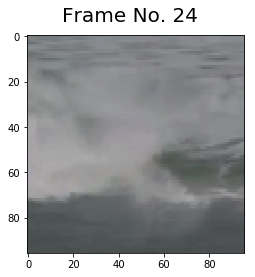

In [10]:
augmentedVideo = final_transformation(video)

newRandomFrameIdx = np.random.randint(0, augmentedVideo.shape[1])

# Since there is the Normalization applied, must de apply it.
augmentedVideo = augmentedVideo.numpy().transpose(1, 2, 3, 0)
augmentedVideo = augmentedVideo * stdDev + medium

for idx, frame in enumerate(augmentedVideo):
    showFrame(frame, f"Frame No. {idx}")

## Performance

This is just a test to show how the performance of the transformation are.
Since we have got 13k videos in our dataset, it is better to take a look at performance.

In [16]:
video = readVideoImageio(video_raw_paths[randomVideoIdx])
print("Transforming original video by downScaling with bilinear interpolation method:")
%timeit final_transformation(video)
print("\n")

nearest_transformation = Compose([  TransposeChannels(),
                            RandomTemporalCrop(max_frame),
                            SpatialRandomCrop( (img_size * 2, img_size * 3) ),
                            RandomHorizontalFlip(),
                            TransposeChannels(reverse = True),
                            Resize((img_size, img_size), interpolation='nearest'),
                            ColorJitter(brightness = 0.2, contrast = 0.7, saturation = 0.5, hue = 0.1), #Max Values for Color Jitter
                            ClipToTensor(div_255= True),
                            Normalize(medium, stdDev)
                         ])

print("Transforming original video by downScaling with nearest interpolation method:")
%timeit nearest_transformation(video)
print("\n")

transformation = Compose([  TransposeChannels(),
                            RandomTemporalCrop(max_frame),
                            RandomHorizontalFlip(),
                            TransposeChannels(reverse = True),
                            ColorJitter(brightness = 0.2, contrast = 0.7, saturation = 0.5, hue = 0.1), #Max Values for Color Jitter
                            ClipToTensor(div_255= True),
                            Normalize(medium, stdDev)
                         ])

video = readVideoImageio( video_paths[randomVideoIdx]) #Taken from Resized Data
print("Transforming resized video by downScaling done offline:")
%timeit transformation(video)

Transforming original video by downScaling with bilinear interpolation method:
30.5 ms ± 988 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Transforming original video by downScaling with nearest interpolation method:
29.8 ms ± 890 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Transforming resized video by downScaling done offline:
28 ms ± 668 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Discussion

Since 13k videos are in the dataset, the total overhead for applying transformation is `405.65s` for the first pipeline, 
`372.4s` for the last one.

However, if the Resize implementation will be changed from `bilinear` to `nearest`, the performance would be better with respect to the first pipeline and come to `396.34s`.

Remember that this results are not accurated because this was not done by profiling methods.

However, even if more time is wasted doing transformations, the first pipeline would be useful because some useless context will be cropped out and the action would be taken in the majority of cases.

## Calculate Mean and Std of UCF_101

Since no statistics were found about Mean and Std of each of the channels (R, G, B) were found online, a Statistics Calculator was implemented to find out these data.
In this way, the normalization that will be done, before giving the data to the Neural Networks will be more effective on backpropagation.

In [4]:
from mocogan.models import UCF_101
from torch.utils.data import DataLoader
from mocogan.utils import StatisticsCalculator

dataset = UCF_101(video_raw_dir, supportedExtensions= ["avi"])
dataloader = DataLoader(dataset, batch_size= 1, num_workers= 4)

stat = StatisticsCalculator(dataloader)

medium, std = stat.start()

medium, std

  0%|          | 0/13320 [00:00<?, ?it/s]

Starting routine for Mean values in dimension [0, 1, 2] of each element.


  0%|          | 0/13320 [00:00<?, ?it/s]

Finded medium values: [100.99800554447337, 96.7195209000943, 89.63882431650443]


Starting routine for Std deviation in dimension [0, 1, 2] of each element.


100%|██████████| 13320/13320 [1:08:45<00:00,  3.33it/s]


([100.99800554447337, 96.7195209000943, 89.63882431650443],
 [72.07041943699456, 70.41506399740703, 71.55581999303428])